In [1]:
import requests as req
import pandas as pd
import json
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pytz

In [2]:
tz = pytz.timezone('Europe/Berlin')

tz.localize(datetime.today()).date()

datetime.date(2022, 3, 4)

In [3]:
def api_wrapper(query, start_date, api_key):
    api_str = f'https://content.guardianapis.com/search?q="{query}"&from-date={start_date}&order-by=oldest&api-key={api_key}&type=article&page-size=50&show-fields=body'
    # &query-fields=headline  don't know if I want or should use this
    response = req.get(api_str).content
    response_json = json.loads(response)
    cols = ['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl', 'body']
    df = pd.DataFrame(columns = cols)
    return response_json, api_str, df

In [4]:
def data_to_df(response_json, api_str, df):  
    pages = response_json['response']['pages']
    for i in range(1, pages + 1):
        response = req.get(api_str + f'&page={i}').content
        response_json = json.loads(response)
        for entry in response_json['response']['results']:
            keys = ['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl']
            write_entry = {k: entry[k] for k in keys}
            write_entry['body'] = entry['fields']['body']
            df = df.append(write_entry, ignore_index=True)
    
    df['Date'] = pd.to_datetime(df['webPublicationDate']).dt.tz_convert(tz='Europe/Berlin')
    df['body'] = df['body'].str.replace(r'<.*?>', '', regex=True)

    return df

In [5]:
def get_result(df):
    df = df.set_index('Date')
    df_grouped = df.groupby(lambda x: x.date).size().reset_index(name='numberOfArticles')
    df_grouped = df_grouped.set_index('index')

    berlin = pytz.timezone('Europe/Berlin')
    date_range = pd.date_range(min(df.index), berlin.localize(datetime.today())).date
    df_grouped = df_grouped.reindex(index = date_range, fill_value=0)

    main_section = df['sectionName'].value_counts().index.tolist()[0]
    avg_articles = df_grouped['numberOfArticles'].mean()
    std_dev = df_grouped['numberOfArticles'].std()

    return df_grouped, main_section, avg_articles, std_dev

In [6]:
query = 'Trudeau'
start_date = '2018-01-01'
api_key = "91f67b2a-520b-4f9f-a4ca-edcb0d610454"

my_json, api_str, df = api_wrapper(query, start_date, api_key)
df = data_to_df(my_json, api_str, df)
result_df, main_section, avg_articles, std_dev = get_result(df)

result_df

,numberOfArticles
index,
2018-01-01,1
2018-01-02,0
2018-01-03,1
2018-01-04,0
2018-01-05,0
...,...
2022-02-27,0
2022-02-28,1
2022-03-01,0


In [7]:
full_df = df

In [8]:
print(avg_articles)
print(std_dev)

0.5745239658568615
1.0575712666999362


In [9]:
pd.date_range(min(df.index), max(df.index)).date

array([datetime.date(1970, 1, 1)], dtype=object)

## Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

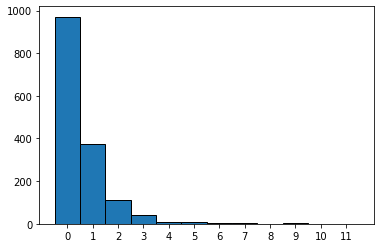

In [10]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.show

<ipython-input-11-2fc9535be686>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<function matplotlib.pyplot.show(close=None, block=None)>

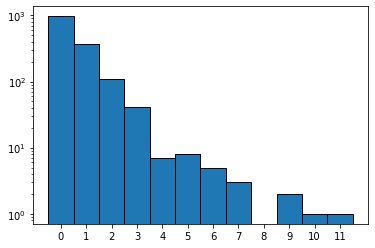

In [11]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.yscale('log', nonposy='clip')
plt.show

In [12]:
# setting window size and confidence level in terms of 
# stander deviations
window_size = 7
num_stds = 3

# calculation of moving average + mean and std deviation
result_df['MA'] = result_df.rolling(window=window_size).mean()
ma_mean = result_df['MA'].mean()
ma_std = result_df['MA'].std()

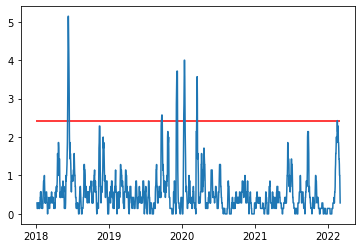

In [13]:
# visualization of the moving average
# and the std line
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots()
ax.plot(result_df.index, result_df.MA)
ax.hlines(y=ma_mean + num_stds * ma_std, xmin=min(result_df.index), xmax=max(result_df.index), color='r')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(years_fmt)

In [14]:
# create df containing spikes in articles
pd.set_option('display.max_rows', 100)
spikes_df = result_df.loc[result_df.MA > ma_mean + num_stds * ma_std ]

In [15]:
spikes_df['date'] = spikes_df.index
# test_df['delta'] = (test_df['date'] - test_df['date'].shift()).fillna(pd.Timedelta(0))
groups = spikes_df['date'].diff().gt(f'{window_size} days').cumsum()
dfs = [x for _, x in spikes_df.groupby(groups)]
print(len(dfs))
dfs

6


<ipython-input-15-51b5b66b8efb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spikes_df['date'] = spikes_df.index


[            numberOfArticles        MA        date
 index                                             
 2018-06-09                 5  2.571429  2018-06-09
 2018-06-10                 5  3.142857  2018-06-10
 2018-06-11                 9  4.428571  2018-06-11
 2018-06-12                 6  5.142857  2018-06-12
 2018-06-13                 2  5.142857  2018-06-13
 2018-06-14                 1  4.714286  2018-06-14
 2018-06-15                 3  4.428571  2018-06-15
 2018-06-16                 0  3.714286  2018-06-16
 2018-06-17                 1  3.142857  2018-06-17,
             numberOfArticles        MA        date
 index                                             
 2019-09-21                 1  2.428571  2019-09-21
 2019-09-22                 0  2.428571  2019-09-22
 2019-09-23                 1  2.571429  2019-09-23
 2019-09-24                 2  2.571429  2019-09-24
 2019-09-25                 1  2.571429  2019-09-25,
             numberOfArticles        MA        date
 index    

In [16]:
# probably makes everything easier
result_df['date'] = pd.to_datetime(result_df.index).date

In [17]:
# for df in dfs:
#     df = result_df.loc[(result_df.date >= df.iloc[0].date - pd.to_timedelta(f'{window_size} days')) &
#                     (result_df.date <= df.iloc[-1].date)]
dfs = [result_df.loc[(result_df.date >= df.iloc[0].date - pd.to_timedelta(f'{window_size} days')) &
                    (result_df.date <= df.iloc[-1].date)] for df in dfs]

## Topic Modelling

In [75]:
# data preparation

# creating lda test data set
full_df.Date = pd.to_datetime(full_df.Date).dt.date
lda_df = full_df.loc[full_df.Date.isin(dfs[2].date)]

# # tokenize sentences
# from nltk.tokenize import sent_tokenize
# # needed downlaod for tokenization
# from nltk import download as nltk_download
# nltk_download('punkt')
# lda_df['sentences'] = lda_df.body.map(sent_tokenize)


# # tokenize words
# from nltk.tokenize import word_tokenize
# lda_df['words'] = lda_df.sentences.map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

# # word tokens with POS-tags
# from nltk import pos_tag_sents
# nltk_download('averaged_perceptron_tagger')
# lda_df['test'] = lda_df.words.map(pos_tag_sents)
# lda_df['test']

In [76]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')
sent = "That's a test, bitch! Fuck OFF!"
doc = nlp(sent)


2022-03-04 05:46:05 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-03-04 05:46:05 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2022-03-04 05:46:05 INFO: Use device: cpu
2022-03-04 05:46:05 INFO: Loading: tokenize
2022-03-04 05:46:05 INFO: Loading: pos
2022-03-04 05:46:05 INFO: Loading: lemma
2022-03-04 05:46:05 INFO: Done loading processors!


In [77]:
def lemmatize_sen(text):
    doc = nlp(text)
    lemmatized_sen =[]
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.upos != "PUNCT":
                lemmatized_sen.append(word.lemma)
    return lemmatized_sen

lda_df['lemmas'] = lda_df['body'].apply(lemmatize_sen)
lda_df['lemmas']

<ipython-input-77-33ec731e702c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_df['lemmas'] = lda_df['body'].apply(lemmatize_sen)


443    [as, the, Queen, host, world, leader, to, mark...
444    [Nato, disunity, be, on, full, display, on, th...
445    [good, morning, I, be, Tim, Walker, with, toda...
446    [a, video, have, emerge, that, appear, to, sho...
447    [seventy, year, after, Nato, be, found, to, pr...
448    [give, the, event, be, potentially, awkward, f...
449    [a, furious, Donald, Trump, cut, short, he, at...
450    [it, be, war, the, summit, that, be, mean, to,...
451    [Canada, 's, log, industry, have, a, larger, a...
452    [Trump, 's, UK, visit, end, without, damage, J...
453    [good, morning, this, be, Richard, Parkin, bri...
454    [democratic, presidential, hopeful, Joe, Biden...
455    [we, have, a, week, to, go, before, election, ...
456    [good, morning, I, be, Tim, Walker, with, toda...
457    [Donald, Trump, throw, a, tantrum, at, the, Na...
458    [a, mysterious, group, have, use, some, of, Fa...
459    [the, message, from, Israel, arrive, on, a, ot...
460    [you, know, that, classi

In [78]:
# creating data and bigrams
from gensim.models import Phrases
tokens = lda_df.lemmas.tolist()
bigram_model = Phrases(tokens)
tokens = [bigram_model[text] for text in tokens]

In [79]:
# creating dictionary and corpus
from gensim import corpora
LDA_dict = corpora.Dictionary(tokens)
LDA_dict.filter_extremes(no_below=3)
corpus = [LDA_dict.doc2bow(t) for t in tokens]

In [80]:
# running LDA
from gensim import models
np.random.seed(69)
num_topics = 1
lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=LDA_dict, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(LDA_dict.keys()))

In [81]:
lda_model.show_topics(num_words=20)

[(0,
  '0.006*"page" + 0.006*"Facebook" + 0.006*"network" + 0.005*"Guardian" + 0.005*"post" + 0.005*"Johnson" + 0.005*"my" + 0.005*"Macron" + 0.004*"use" + 0.004*"group" + 0.004*"before" + 0.003*"video" + 0.003*"attack" + 0.003*"share" + 0.003*"because" + 0.003*"off" + 0.003*"ask" + 0.003*"member" + 0.003*"content" + 0.003*"comment"')]

TODO:  
- finish topic modelling
  - remove stopwords
  - check what else maybe has to be removed
  - implement it in function to call for all dfs returning useful output
  - clean code
- add visualization of developement over time
- add better viz for confidence interval
- get automation going
- create email / pdf report from findings